# Agricultural dataset
---
In this notebook, we train a image classification algorithms to classify images from the Agricultural-crops dataset.


<img src='notebook_ims/cifar_data.png' width=50% height=50% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Mlflow
import mlflow
import mlflow.pytorch

In [2]:
torch.cuda.is_available()

True

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
 
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
!nvidia-smi

Fri May 31 11:41:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.24                 Driver Version: 546.24       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               2W /  55W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---
## Load the [Data](https://pytorch.org/vision/stable/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [5]:
import os
from pathlib import Path

import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image


# class AgriculturalCropDataset(Dataset):
#     def __init__(self, data_path, transform=None, target_transform=None):

#         labels = {
#             "almond": 0,
#             "banana": 1,
#             "cardamom": 2,
#             "Cherry": 3,
#             "chilli": 4,
#             "clove": 5,
#             "coconut": 6,
#             "Coffee-plant": 7,
#             "cotton": 8,
#             "Cucumber": 9,
#             "Fox_nut": 10,
#             "gram": 11,
#             "jowar": 12,
#             "jute": 13,
#             "Lemon": 14,
#             "maize": 15,
#             "mustard-oil": 16,
#             "Olive-tree": 17,
#             "papaya": 18,
#             "Pearl_millet": 19,
#             "pineapple": 20,
#             "rice": 21,
#             "soyabean": 22,
#             "sugarcane": 23,
#             "sunflower": 24,
#             "tea": 25,
#             "Tobacco-plant": 26,
#             "tomato": 27,
#             "vigna-radiati": 28,
#             "wheat": 29,
#         }

#         file_paths = []
#         for file_path in data_path.rglob('*.*'):  # Adjust the pattern as needed
#             if file_path.is_file():
#                 file_paths.append([file_path, labels[file_path.parent.stem]])

#         self.img_annotations = pd.DataFrame(file_paths, columns=["path", "target"])
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_annotations)

#     def __getitem__(self, idx):
#         img_path = str(self.img_annotations.iloc[idx, 0])
#         # image = read_image(img_path)
#         image = Image.open(img_path).convert('RGB')
#         label = self.img_annotations.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label




In [6]:
# def read_data_cifar():
#     # Data transform to convert data to a tensor and apply normalization

#     # augment train and validation dataset with RandomHorizontalFlip and RandomRotation
#     train_transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(), # randomly flip and rotate
#         transforms.RandomRotation(10),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])

#     test_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])

#     # choose the training and test datasets
#     train_data = datasets.CIFAR10('data', train=True,
#                                 download=True, transform=train_transform)
#     test_data = datasets.CIFAR10('data', train=False,
#                                 download=True, transform=test_transform)

#     return train_data, test_data

# def read_data():
#     # Data transform to convert data to a tensor and apply normalization

#     current_working_directory  = Path.cwd()
#     data_path = current_working_directory.parent / "data" / "Agricultural-crops"


#     # augment train and validation dataset with RandomHorizontalFlip and RandomRotation
#     train_transform = transforms.Compose([
#         transforms.RandomResizedCrop(size=(256, 256)),
#         transforms.RandomHorizontalFlip(), # randomly flip and rotate
#         transforms.RandomRotation(10),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])

#     # test_transform = transforms.Compose([
#     #     transforms.ToTensor(),
#     #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     #     ])

#     dataset = AgriculturalCropDataset(data_path=data_path, transform=train_transform)

#     return dataset


In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit


# def get_split_index(dataset, test_size=0.2):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

#     train_index, test_index = next(sss.split(list(range(len(dataset))), dataset.img_annotations['target'].to_list()))
#     train_index, valid_index = next(sss.split(train_index, dataset.img_annotations.iloc[train_index, 1].to_list()))
#     return train_index, valid_index, test_index

In [8]:
current_working_directory  = Path.cwd()
data_path = current_working_directory.parent / "data" / "Agricultural-crops"
new_data_path = data_path.parent / "Agricultural-crops-new"

In [134]:
import shutil
from sklearn.model_selection import StratifiedShuffleSplit


labels = {
    "almond": 0,
    "banana": 1,
    "cardamom": 2,
    "Cherry": 3,
    "chilli": 4,
    "clove": 5,
    "coconut": 6,
    "Coffee-plant": 7,
    "cotton": 8,
    "Cucumber": 9,
    "Fox_nut": 10,
    "gram": 11,
    "jowar": 12,
    "jute": 13,
    "Lemon": 14,
    "maize": 15,
    "mustard-oil": 16,
    "Olive-tree": 17,
    "papaya": 18,
    "Pearl_millet": 19,
    "pineapple": 20,
    "rice": 21,
    "soyabean": 22,
    "sugarcane": 23,
    "sunflower": 24,
    "tea": 25,
    "Tobacco-plant": 26,
    "tomato": 27,
    "vigna-radiati": 28,
    "wheat": 29,
}

file_paths = []
for file_path in data_path.rglob('*.*'):  # Adjust the pattern as needed
    if file_path.is_file():
        file_paths.append([file_path, file_path.parent.stem])

df_img_annotations = pd.DataFrame(file_paths, columns=["path", "target"])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.13, random_state=42)

train_index, test_index = next(sss.split(list(range(len(df_img_annotations))), df_img_annotations['target'].to_list()))

new_df_img_annotations = df_img_annotations.iloc[train_index, :].reset_index()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_index, valid_index = next(sss.split(list(range(len(new_df_img_annotations))), new_df_img_annotations['target'].to_list()))

print(len(train_index))
print(len(valid_index))
print(len(test_index))

new_data_path = data_path.parent / "Agricultural-crops-new"
new_data_path.mkdir(parents=True, exist_ok=True)

# Create test folder
for index, row in df_img_annotations.iloc[test_index,:].iterrows():
    current_folder = new_data_path / "test" / row['path'].parent.stem
    current_folder.mkdir(parents=True, exist_ok=True)
    shutil.copy(str(row['path']), str(current_folder))


# Create train folder
for index, row in new_df_img_annotations.iloc[train_index,:].iterrows():
    current_folder = new_data_path / "train" / row['path'].parent.stem
    current_folder.mkdir(parents=True, exist_ok=True)
    shutil.copy(str(row['path']), str(current_folder))


# # Create val folder
for index, row in new_df_img_annotations.iloc[valid_index,:].iterrows():
    current_folder = new_data_path / "valid" / row['path'].parent.stem
    current_folder.mkdir(parents=True, exist_ok=True)
    shutil.copy(str(row['path']), str(current_folder))


648
73
108


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(new_data_path / x,
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
dataset_sizes

{'train': 648, 'valid': 73, 'test': 108}

In [11]:
# def feature_engineering_cifar(train_data, test_data):
#     # number of subprocesses to use for data loading
#     num_workers = 0
#     # how many samples per batch to load
#     batch_size = 20
#     # percentage of training set to use as validation
#     valid_size = 0.2

#     # obtain training indices that will be used for validation
#     num_train = len(train_data)
#     indices = list(range(num_train))
#     np.random.shuffle(indices)
#     split = int(np.floor(valid_size * num_train))
#     train_idx, valid_idx = indices[split:], indices[:split]

#     # define samplers for obtaining training and validation batches
#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)

#     # prepare data loaders (combine dataset and sampler)
#     train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#         sampler=train_sampler, num_workers=num_workers)
#     valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
#         sampler=valid_sampler, num_workers=num_workers)
#     test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#         num_workers=num_workers)
    
#     return train_loader, valid_loader, test_loader

def feature_engineering(data_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


    image_datasets = {x: datasets.ImageFolder(data_path / x,
                                            data_transforms[x])
                    for x in ['train', 'valid', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                                shuffle=True, num_workers=0)
                for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    class_names = image_datasets['train'].classes
    return image_datasets, dataloaders, dataset_sizes, class_names

image_datasets, dataloaders, dataset_sizes, class_names = feature_engineering(new_data_path)
train_loader, valid_loader, test_loader = dataloaders['train'], dataloaders['valid'], dataloaders['test']

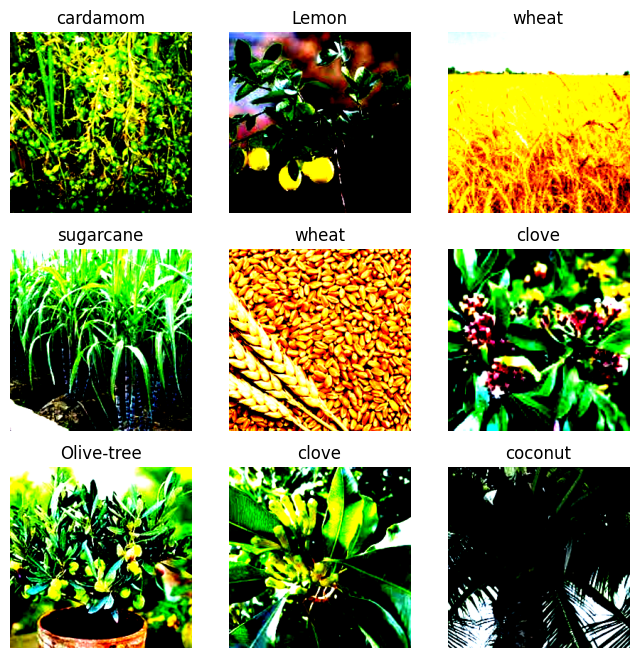

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_datasets['valid']), size=(1,)).item()
    img, label = image_datasets['valid'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze())
plt.show()

In [13]:
import torch.nn.functional as F

# define the CNN architecture
class CNN_agri(nn.Module):
    def __init__(self):
        super(CNN_agri, self).__init__()
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 126x128x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 32 * 32 -> 262144)
        self.fc1 = nn.Linear(64 * 32 * 32, 40)
        # linear layer (262144 -> 30)
        self.fc2 = nn.Linear(40, 30)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 32 * 32)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        # x = F.softmax(self.fc2(x))
        x = self.fc2(x)
        return x

# class CNN_cifar(nn.Module):
#     def __init__(
#             self,
#             conv1: int,
#             conv2: int,
#             conv3: int,
#             kernel: int,
#             padding: int,
#             dropout: float,
#             fc1: int
#         ):
#         super(CNN_cifar, self).__init__()
#         # convolutional layer (sees 32x32x3 image tensor)
#         self.conv1 = nn.Conv2d(3, conv1, kernel, padding=padding)
#         # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(conv1, conv2, kernel, padding=padding)
#         # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(conv2, conv3, kernel, padding=padding)
#         # max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
#         # linear layer (64 * 4 * 4 -> 500)
#         self.fc1 = nn.Linear(conv3 * 4 * 4, fc1)
#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(fc1, 10)
#         # dropout layer (p=0.25)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         # flatten image input
#         x = x.view(-1, 64 * 4 * 4)
#         # add dropout layer
#         x = self.dropout(x)
#         # add 1st hidden layer, with relu activation function
#         x = F.relu(self.fc1(x))
#         # add dropout layer
#         x = self.dropout(x)
#         # add 2nd hidden layer, with relu activation function
#         x = self.fc2(x)
#         return x

In [14]:
from abc import ABC, abstractmethod

from torchvision.models import vgg16, resnet50, googlenet, efficientnet_v2_s

models_dict = {
    'vgg16': vgg16,
    'resnet50': resnet50,
    'googlenet': googlenet,
    'efficientnet_v2_s': efficientnet_v2_s
}


class BasePretrainedModel(ABC):
    @abstractmethod
    def __init__(self, model_name, pretrained, num_classes):
        pass

    def freeze_features(self):
        """Freezes the training for all feature layers."""
        for param in self.model.parameters():
            param.requires_grad = False

    @abstractmethod
    def adapt_last_layer(self, num_classes):
        """
        Adapts the last layer of the model for the given number of classes.
        
        Args:
            num_classes (int): The number of output classes.
        """
        pass


class PretrainedModel(BasePretrainedModel):
    def __init__(self, model_name, pretrained=True, num_classes=30):
        # Load model
        self.model_name = model_name
        self.model = models_dict[self.model_name](pretrained=pretrained)
        self.freeze_features()
        self.adapt_last_layer(num_classes=num_classes)

        if torch.cuda.is_available():
            self.model.cuda()
    
    def adapt_last_layer(self, num_classes):

        if self.model_name in ['vgg16', 'efficientnet_v2_s']:
            n_inputs = self.model.classifier[-1].in_features
            last_layer = nn.Linear(n_inputs, num_classes)
            self.model.classifier[-1] = last_layer
        else:
            n_inputs = self.model.fc.in_features
            last_layer = nn.Linear(n_inputs, num_classes)
            self.model.fc = last_layer

# pre_model = PretrainedModel(model_name='efficientnet_v2_s', pretrained=True, num_classes=30)
# model = pre_model.model

In [15]:
# Load the pretrained model from pytorch
# vgg16 = models.vgg16(pretrained=True)
# print(vgg16)
# resnet50 = models.resnet50(pretrained=True)
# print(resnet50)

# inception_v3 = models.vgg16(pretrained=True)
# print(inception_v3)

In [59]:
# print(vgg16.classifier[6].in_features)
# print(vgg16.classifier[6].out_features)
print(resnet50.fc.in_features)
print(resnet50.fc.out_features)

2048
1000


In [16]:
# Freeze training for all "features" layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

In [17]:
# n_inputs = vgg16.classifier[6].in_features

# # add last linear layer (n_inputs -> 5 flower classes)
# # new layers automatically have requires_grad = True
# last_layer = nn.Linear(n_inputs, 30)

# vgg16.classifier[6] = last_layer

# # if GPU is available, move the model to GPU
# if train_on_gpu:
#     vgg16.cuda()

# # check to see that your last layer produces the expected number of outputs
# print(vgg16.classifier[6].out_features)

In [18]:
def train_test_model(train_loader, valid_loader, test_loader, model, params):
    
    with mlflow.start_run(run_name=params['run_name']) as run:
        # Params

        mlflow.log_params(params)
        if train_on_gpu:
            model.cuda()
        # specify loss function (categorical cross-entropy)
        criterion = nn.CrossEntropyLoss()

        # specify optimizer ## TODO
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        # optimizer = optim.Adam(model.parameters(), lr=0.01)

        # number of epochs to train the model
        n_epochs = params['n_epochs']

        valid_loss_min = np.Inf # track change in validation loss

        for epoch in range(1, n_epochs+1):

            # keep track of training and validation loss
            train_loss = 0.0
            valid_loss = 0.0
            
            ###################
            # train the model #
            ###################
            model.train()
            for data, target in train_loader:
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update training loss
                train_loss += loss.item()*data.size(0)
                
            ######################    
            # validate the model #
            ######################
            model.eval()
            for data, target in valid_loader:
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
            
            # calculate average losses
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            
            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, train_loss, valid_loss))
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("valid_loss", valid_loss, step=epoch)

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), '../models/model_agriculture_crop.pt')
                valid_loss_min = valid_loss
            mlflow.pytorch.log_model(model, "models")
            mlflow.pytorch.save_model


        # test
        # track test loss
        test_loss = 0.0
        
        # class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] ## TODO
        class_correct = list(0. for i in range(len(params['class_names'])))
        class_total = list(0. for i in range(len(params['class_names'])))
    

        model.eval()
        # iterate over test data
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(len(data)): ## TODO
                # print(len(data))
                label = target.data[i]
                # print(label)
                # print(class_correct[label])
                # print(correct[i].item())
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))
        mlflow.log_metric("avg_test_loss", test_loss)

        for i in range(len(params['class_names'])):
            if class_total[i] > 0:
                class_accuracy = 100 * class_correct[i] / class_total[i]
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    params['class_names'][i], class_accuracy,
                    np.sum(class_correct[i]), np.sum(class_total[i])))
                mlflow.log_metric(f"test_accuracy_{params['class_names'][i]}", class_accuracy)
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (params['class_names'][i]))

        test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
            test_accuracy,
            np.sum(class_correct), np.sum(class_total)))
        mlflow.log_metric("test_accuracy_overall", test_accuracy)


In [19]:
def main_flow(run_name, model_name) -> None:
    # Set mlflow
    TRACKING_SERVER_HOST = "localhost"
    mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
    mlflow.set_experiment("Agricultural-crops-experiments")

    # Feature engineering step
    data_path = Path.cwd().parent / "data" / "Agricultural-crops-new"
    _, dataloaders, dataset_sizes, class_names = feature_engineering(data_path)
    train_loader, valid_loader, test_loader = dataloaders['train'], dataloaders['valid'], dataloaders['test']

    # Select model to train
    if model_name == 'own':
        model = CNN_agri()
    else:
        pre_model = PretrainedModel(model_name=model_name, pretrained=True, num_classes=30)
        model = pre_model.model
    
    # Train model
    params = {
            "class_names": class_names,
            "dataset_sizes": dataset_sizes,
            "n_epochs": 10,
            "criterion": "CrossEntropyLoss",
            "optimizer": "SGD",
            "run_name": run_name
        }
    train_test_model(train_loader, valid_loader, test_loader, model, params)

# def cifar_flow() -> None:
#     TRACKING_SERVER_HOST = "localhost"
#     mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
#     mlflow.set_experiment("cifar-experiments")

#     train_data, test_data = read_data_cifar()

#     train_loader, valid_loader, test_loader = feature_engineering_cifar(train_data, test_data)

#     train_test_model(train_loader, valid_loader, test_loader)

In [25]:
# main_flow(run_name='CNN_agri_1', model_name='own')
# main_flow(run_name='vgg16_1', model_name='vgg16')
# main_flow(run_name='resnet50_1', model_name='resnet50')
# main_flow(run_name='efficientnet_v2_s_1', model_name='efficientnet_v2_s')
main_flow(run_name='googlenet_1', model_name='googlenet')

c:\Users\luisg\Documents\projects\cifar-CNN\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2024/05/31 11:58:13 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 1 	Training Loss: 3.405918 	Validation Loss: 3.294811
Validation loss decreased (inf --> 3.294811).  Saving model ...


2024/05/31 11:58:15 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 2 	Training Loss: 3.295408 	Validation Loss: 3.180043
Validation loss decreased (3.294811 --> 3.180043).  Saving model ...


2024/05/31 11:58:24 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:58:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:58:35 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version l

Epoch: 3 	Training Loss: 3.170028 	Validation Loss: 3.078442
Validation loss decreased (3.180043 --> 3.078442).  Saving model ...


2024/05/31 11:58:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:58:47 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 4 	Training Loss: 3.087844 	Validation Loss: 2.980390
Validation loss decreased (3.078442 --> 2.980390).  Saving model ...


2024/05/31 11:58:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:58:58 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 5 	Training Loss: 2.967168 	Validation Loss: 2.883995
Validation loss decreased (2.980390 --> 2.883995).  Saving model ...


2024/05/31 11:59:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:59:09 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 6 	Training Loss: 2.859050 	Validation Loss: 2.793122
Validation loss decreased (2.883995 --> 2.793122).  Saving model ...


2024/05/31 11:59:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:59:19 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 7 	Training Loss: 2.785196 	Validation Loss: 2.703410
Validation loss decreased (2.793122 --> 2.703410).  Saving model ...


2024/05/31 11:59:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:59:28 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 8 	Training Loss: 2.674586 	Validation Loss: 2.624767
Validation loss decreased (2.703410 --> 2.624767).  Saving model ...


2024/05/31 11:59:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:59:36 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 9 	Training Loss: 2.609246 	Validation Loss: 2.539904
Validation loss decreased (2.624767 --> 2.539904).  Saving model ...


2024/05/31 11:59:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/31 11:59:46 WARNING mlflow.utils.requirements_utils: Found torch version (1.12.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.12.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch: 10 	Training Loss: 2.503575 	Validation Loss: 2.469272
Validation loss decreased (2.539904 --> 2.469272).  Saving model ...


2024/05/31 11:59:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.13.1+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torchvision==0.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Test Loss: 2.448062

Test Accuracy of Cherry: 75% ( 3/ 4)
Test Accuracy of Coffee-plant:  0% ( 0/ 4)
Test Accuracy of Cucumber: 100% ( 4/ 4)
Test Accuracy of Fox_nut: 100% ( 3/ 3)
Test Accuracy of Lemon: 50% ( 2/ 4)
Test Accuracy of Olive-tree:  0% ( 0/ 4)
Test Accuracy of Pearl_millet: 100% ( 5/ 5)
Test Accuracy of Tobacco-plant: 100% ( 4/ 4)
Test Accuracy of almond: 33% ( 1/ 3)
Test Accuracy of banana: 100% ( 4/ 4)
Test Accuracy of cardamom:  0% ( 0/ 3)
Test Accuracy of chilli: 33% ( 1/ 3)
Test Accuracy of clove: 50% ( 2/ 4)
Test Accuracy of coconut: 100% ( 3/ 3)
Test Accuracy of cotton: 100% ( 4/ 4)
Test Accuracy of  gram: 33% ( 1/ 3)
Test Accuracy of jowar: 25% ( 1/ 4)
Test Accuracy of  jute: 66% ( 2/ 3)
Test Accuracy of maize: 75% ( 3/ 4)
Test Accuracy of mustard-oil: 50% ( 2/ 4)
Test Accuracy of papaya:  0% ( 0/ 3)
Test Accuracy of pineapple: 66% ( 2/ 3)
Test Accuracy of  rice: 100% ( 4/ 4)
Test Accuracy of soyabean: 75% ( 3/ 4)
Test Accuracy of sugarcane: 33% ( 1/ 3)
Test Accura

In [76]:
mlflow.end_run()

In [26]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
import os

# os.environ["AWS_ACCESS_KEY_ID"] = ""
# os.environ["AWS_SECRET_ACCESS_KEY"] = ""

# TRACKING_SERVER_HOST = "ec2-54-89-145-30.compute-1.amazonaws.com" # fill in with the public DNS of the EC2 instance
TRACKING_SERVER_HOST = "localhost"
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
mlflow.set_experiment("Agricultural-crops-experiments")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1717177586097, experiment_id='1', last_update_time=1717177586097, lifecycle_stage='active', name='Agricultural-crops-experiments', tags={}>

### Visualize a Batch of Training Data

In [23]:
import pandas as pd

data_path = Path.cwd().parent / "data" / "Agricultural-crops-new"
_, dataloaders, dataset_sizes, class_names = feature_engineering(data_path)
train_loader, valid_loader, test_loader = dataloaders['train'], dataloaders['valid'], dataloaders['test']

Files already downloaded and verified
Files already downloaded and verified


In [71]:
from pprint import pprint
from mlflow import MlflowClient

client = MlflowClient()
logged_model = [mv.source for idx, mv in enumerate(client.search_model_versions("name='prod.image_classification'")) if idx == 0][0]
logged_model

'models:/staging.image_classification/1'

In [72]:
import mlflow

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models
  flavor: mlflow.pytorch
  run_id: 8bde21ab9c214e2ba624b6ae8974fd20

In [73]:
# Load model as a Pytorch model.
# loaded_model = mlflow.pytorch.load_model(logged_model)
# loaded_model.eval().cpu()
# loaded_model.eval()


def predict(image):
    image.numpy()

    # move model inputs to cuda, if GPU available
    image = image.cpu()

    # get sample outputs
    output = loaded_model(image)

    soft_output = torch.softmax(output, 1)
    score, pred = torch.max(soft_output, 1)

    return {"pred": float(pred[0]), "score": float(score[0])}

In [77]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
# images[0, :, :, :].shape
images.shape

image = images.numpy()

output = loaded_model.predict(image)

# predict(images[0, :, :, :])

In [96]:
def softmax(x):
  """
  Computes the softmax of an input vector x.

  Args:
    x: A numpy array.

  Returns:
    A numpy array containing the softmax of the input.
  """
  exp_scores = np.exp(x)
  return exp_scores / np.sum(exp_scores, axis=0, keepdims=True)

exp_scores = np.exp(output)
soft_output = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
soft_output
pred = np.argmax(soft_output, 1)
pred

array([ 8,  4, 18, 12,  0, 21, 26, 25,  3,  2, 24, 16, 28,  4, 19,  5, 14,
        6, 29, 22], dtype=int64)

In [105]:
from torchvision import utils

# Assuming 'tensor_image' is your PyTorch tensor
# You can use the tensor you obtained from the previous example

# Specify the file path where you want to save the image
output_path = "output_image1.png"

tensor_image = images[15, :, :, :]

# Save the tensor as an image
utils.save_image(tensor_image, output_path)

print(f"Image saved to: {output_path}")

Image saved to: output_image1.png


###  Load the Model with the Lowest Validation Loss

In [95]:
params = {
    "conv1": 16,
    "conv2": 32,
    "conv3": 64,
    "kernel": 3,
    "padding": 1,
    "dropout": 0.05,
    "fc1": 40,
    "n_epochs": 1,
    "criterion": "CrossEntropyLoss",
    "optimizer": "SGD"
}

# create a complete CNN
loaded_model = Net(
    conv1 = params['conv1'],
    conv2 = params['conv2'],
    conv3 = params['conv3'],
    kernel = params['kernel'],
    padding = params['padding'],
    dropout = params['dropout'],
    fc1 = params['fc1']
)


In [97]:
loaded_model.load_state_dict(torch.load('models/model_agriculture_crop.pt'))
loaded_model

AttributeError: 'PyFuncModel' object has no attribute 'load_state_dict'

In [104]:
loaded_model.eval().cpu()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

predict(images[10, :, :, :])

{'pred': 0.0, 'score': 0.3828023374080658}

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

Test Loss: 0.663844

Test Accuracy of airplane: 84% (841/1000)
Test Accuracy of automobile: 88% (885/1000)
Test Accuracy of  bird: 61% (612/1000)
Test Accuracy of   cat: 53% (534/1000)
Test Accuracy of  deer: 73% (737/1000)
Test Accuracy of   dog: 71% (715/1000)
Test Accuracy of  frog: 84% (847/1000)
Test Accuracy of horse: 80% (806/1000)
Test Accuracy of  ship: 86% (868/1000)
Test Accuracy of truck: 82% (829/1000)

Test Accuracy (Overall): 76% (7674/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

### Visualize Sample Test Results

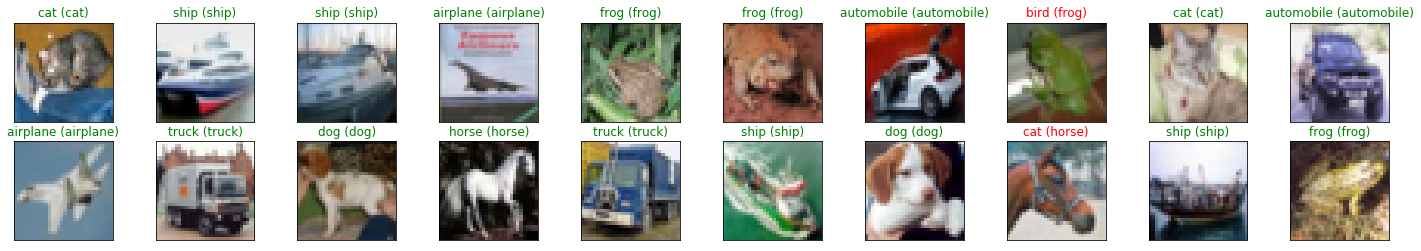

In [42]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))